<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 3 : Groupement hiérarchique de documents

## Résumé
Le but de ce laboratoire est d'appliquer un algorithme de groupement hiérarchique à des résumés de films.  Vous afficherez les résultats et observerez quels paramètres permettent d'obtenir un groupement convenable, car il n'y a pas de vérité-terrain dans ces données.

Les étapes proposées sont les suivantes :
  1. Préparation des documents : pré-traitement des textes des résumés
  2. Création des représentations vectorielles de chaque résumé
  3. Groupement hiérarchique, affichage du dendrogramme, et discussion

## 1. Préparation des documents

Dans ce labo, vous utiliserez les titres et résumés des 100 films classiques (*référence anonymisée*) qui vous sont fournis sur Cyberlearn dans le fichier `movie_data.csv` sur deux colonnes : titres et résumés.

Dans cette première partie, vous allez transformer les textes des résumés pour réduire la diversité du vocabulaire.  Un ensemble de fonctions de préparation vous est fourni dans la librairie `utils.py` (également sur Cyberlearn) et il est conseillé de les lire et de les utiliser.

In [1]:
import itertools

import numpy as np
import pandas as pd
import utils # librairie avec des fonctions de pré-traitement des textes
# elle fait appel à la librairie NLTK (ce qui affiche plusieurs messages)

[nltk_data] Downloading package punkt to /home/hugo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hugo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/hugo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hugo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/hugo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


a. Veuillez charger les données des films depuis le fichier `movie_data.csv` dans une _DataFrame_ intitulée `movie_data`.  Combien de lignes et colonnes a-t-elle et quels sont les intitulés des colonnes ?

In [2]:
movie_data = pd.read_csv("movie_data.csv")
print(movie_data.shape)
movie_data.head(10)

(100, 2)


,Title,Synopsis
0,The Godfather,"In late summer 1945, guests are gathered for t..."
1,The Shawshank Redemption,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,Schindler's List,The relocation of Polish Jews from surrounding...
3,Raging Bull,"The film opens in 1964, where an older and fat..."
4,Casablanca,"In the early years of World War II, December 1..."
5,One Flew Over the Cuckoo's Nest,"In 1963 Oregon, Randle Patrick McMurphy (Nicho..."
6,Gone with the Wind,"The film opens in Tara, a cotton plantation ow..."
7,Citizen Kane,"It's 1941, and newspaper tycoon Charles Foster..."
8,The Wizard of Oz,Dorothy Gale (Judy Garland) is an orphaned tee...
9,Titanic,"In 1996, treasure hunter Brock Lovett and his ..."


**Réponse** : Il y a 100 lignes et 2 colonnes. Cela correspond à 100 films avec un titre (Title) et un synopsis (Synopsis).

b. Veuillez normaliser le texte de chaque résumé en appliquant plusieurs des fonctions fournies dans `utils.py` (pour cela, vous devez examiner ce fichier).  Veuillez stocker les textes normalisés dans une nouvelle colonne de la _DataFrame_.   Il n'est pas nécessaire de tokeniser les textes normalisés, car le _vectorizer_ de sklearn le fera plus loin. 

In [3]:
def text_filter(text):
    for f in (utils.remove_stopwords, utils.remove_punctuation, utils.remove_non_alphabetic):
        text = f(text)
    return text

In [4]:
texts = movie_data["Synopsis"]

movie_data["NormalizedSynopsis"] = texts.apply(text_filter).apply(utils.lemmatize_text)

c. Veuillez analyser la longueur des résumés, avant et après le pré-traitement, grâce au _5-number summary_ de chaque distribution.  Veuillez commenter brièvement l'évolution de la distribution suite au pré-traitement.

In [5]:
synopsis_lengths = movie_data[["Synopsis", "NormalizedSynopsis"]].applymap(len)
synopsis_lengths.describe().loc[["min", "25%", "50%", "75%", "max"]]

,Synopsis,NormalizedSynopsis
min,1071.00,709.00
25%,4378.75,2822.25
50%,6528.50,4182.00
75%,11417.50,7239.50
max,34021.00,22090.00


**Réponse:** On constate que la longueur des résumés normalisés est bien moindre que celle des résumés originaux (médiane des longueurs réduite d'environ 36%)

d. Veuillez afficher un extrait du résumé d'un film *avant* et *après* le pré-traitement et commenter brièvement le résultat.

In [6]:
print("== Original:")
print(movie_data.loc[76]["Synopsis"][0:400]) # un bon film
print("== Normalized:")
print(movie_data.loc[76]["NormalizedSynopsis"][0:400])

== Original:
The movie opens with a car towing a new tan Oldsmobile Cutlass Ciera through a sub-freezing blizzard to a small inn in Fargo, North Dakota. It is 8:30 p.m. on a cold night in January 1987. When the driver goes inside, we see that it is Jerry Lundegaard (William H. Macy), and he uses the false name 'Jerry Anderson' to check in. He then goes to the inn's bar/restaurant to have a meeting with two men
== Normalized:
the movie open car tow new tan oldsmobile cutlas ciera sub freeze blizzard small inn fargo north dakota it p m cold night january when driver go inside jerry lundegaard william h macy use false name jerry anderson check he go inn s bar restaurant meet men jerry obviously never meet the short bug eye dark haired annoyed talkative carl showalter steve buscemi tell shep proudfoot mutual acquaintance 


**Réponse**: On constate qu'il n'y a effectivement plus de chiffres, ponctuation et de _stop_words_, avec par example la disparition de l'heure _8:30pm_, des points de ponctuation ainsi que des déterminants 'a'. Les mots restants ont subit une lemmatisation, ils sont en minuscules et transformés en une forme plus courte (infinitif pour les verbes, singulier pour les mots, etc).

## 2. Création des représentations vectorielles

Dans cette partie, vous allez créer pour chaque film une représentation vectorielle avec les coefficients TF-IDF, comme vous l'avez appris en PCD, en utilisant `TfidfVectorizer`.  Veuillez justifier brièvement votre choix de paramètres.

a. Veuillez créer les vecteurs dans un tableau appelé `feature_matrix`, avec autant de lignes que de films.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
vectorizer = TfidfVectorizer(lowercase=False) # Pas besoin de mettre le texte en miniscules car cela a déjà été fait lors de la normalisation. Pour le reste on utilise les paramètres par défaut 

feature_matrix = vectorizer.fit_transform(movie_data["NormalizedSynopsis"])
np.shape(feature_matrix)

(100, 11159)

b. Quel est le nombre de colonnes du tableau `feature_matrix`. Pourquoi ?

**Réponse**: Il y a 100 colonnes, une par résumé de film

c. Veuillez afficher les mots correspondant aux 20 premières dimensions de `feature_matrix`.  (Note : les dimensions sont classées par ordre alphabétique des mots.)

In [9]:
features = vectorizer.get_feature_names_out()
print(features[:20])

['00am' '101st' '11th' '13th' '15th' '16th' '1800s' '18th' '1900s' '1920s'
 '1930s' '1940s' '1950s' '1960s' '1st' '20th' '21st' '25th' '2nd' '30s']


## 3. Groupement hiérarchique
Dans cette section, vous utiliserez un algorithme de groupement hiérarchique et vous afficherez les résultats sous forme de dendrogramme.  Les fonctions utilisées proviendront de `scipy`, comme recommandé par sklearn sous [Plot Hierarchical Clustering Dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html).  Merci de suivre les indications et répondre aux questions suivantes.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import single, complete, average, ward
from scipy.cluster.hierarchy import dendrogram, cut_tree
import matplotlib.pyplot as plt
%matplotlib inline

a. Générer une matrice des distances entre paires de résumés, en utilisant les représentations vectorielles obtenues ci-dessus et la métrique [sklearn.metrics.pairwise.cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).  Attention, le cosinus étant une similarité, prendre _1-cosinus_ pour obtenir des distances. 

In [11]:
distances = 1.0 - cosine_similarity(feature_matrix, feature_matrix)

b. Veuillez utiliser la méthode **ward** de [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) qui effectue le groupement hiérarchique à partir d'une matrice des distances.  Quel est le résultat retourné par la méthode ?

In [12]:
grouping_ward = ward(distances)

print(grouping_ward.shape)
print(grouping_ward[:10])

(99, 4)
[[ 0.         11.          0.65382793  2.        ]
 [ 7.         56.          0.72094121  2.        ]
 [ 8.         75.          0.88878807  2.        ]
 [26.         67.          0.92757832  2.        ]
 [52.         86.          0.96415936  2.        ]
 [ 3.         23.          0.98131077  2.        ]
 [15.         85.          0.98353293  2.        ]
 [27.         76.          0.98716897  2.        ]
 [ 9.         87.          1.0762627   2.        ]
 [17.         18.          1.08207559  2.        ]]


**Réponse**: On obtient une matrice de taille 99x4 qui correspond à l'ordre des _n - 1_ itérations de rapprochement des _n = 100_ groupes.

On commence avec 100 groupes singletons correspondant aux 100 films. Pour chaque itération, on a 4 valeurs où la 1ère et 2ème sont les groupes rapprochés, la 3ème leur distance au moment du rapprochement et la 4ème le nombre de groupes originaux présent dans le nouveau groupe formé (dans notre cas c'est le nombre de films).

Par exemple, on voit ici que les groupes 0 et 11 ont été les premiers à être rapprochés (il s'agit du Parrain et du Parrain II), qu'ils avaient un distance d'environ 0.65 et qu'ils forment désormais un groupe de 2 films.

Quand un nouveau groupe est formé il reçoit un index de valeur _n + i_ où _n_ est le nombre de groupes originaux et _i_ l'itération courante. Dans notre cas, cela veut dire que les groupes originaux (les films) on un index de 0 à 99 et les groupes formés de 2 films et plus ont un index allant de 100 à 199.

c. Afficher le dendrogramme avec la fonction [scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) qui utilise la matrice de liens.  Utiliser l'exemple donné en bas de la page [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html).  Veuillez afficher un dendrogramme aussi lisible que possible, et en particulier veuillez étiqueter chaque feuille avec le nom du film correspondant.

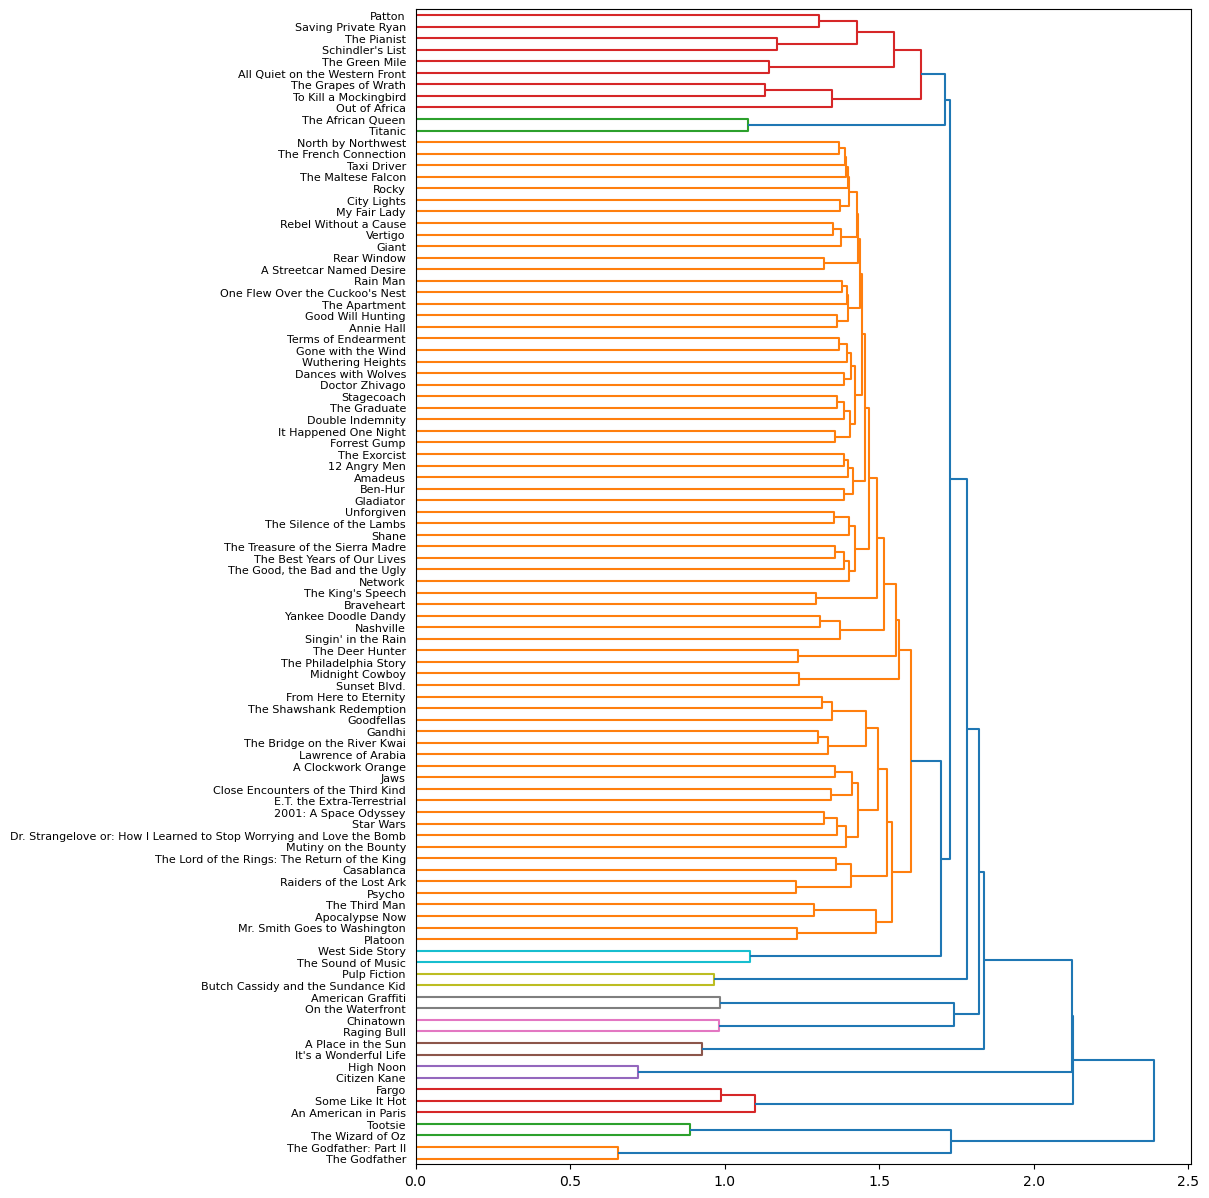

In [13]:
plt.figure(figsize=(10, 15))
_ = dendrogram(grouping_ward, leaf_label_func=lambda i: movie_data["Title"][i], leaf_font_size=8, orientation="right")

d. Veuillez essayer une deuxième méthode de groupement hiérarchique et afficher son dendrogramme.  Comment se compare-t-il au précédent ?  Le trouvez-vous meilleur, moins bon, ou similaire ? 

In [14]:
grouping_complete = complete(distances)

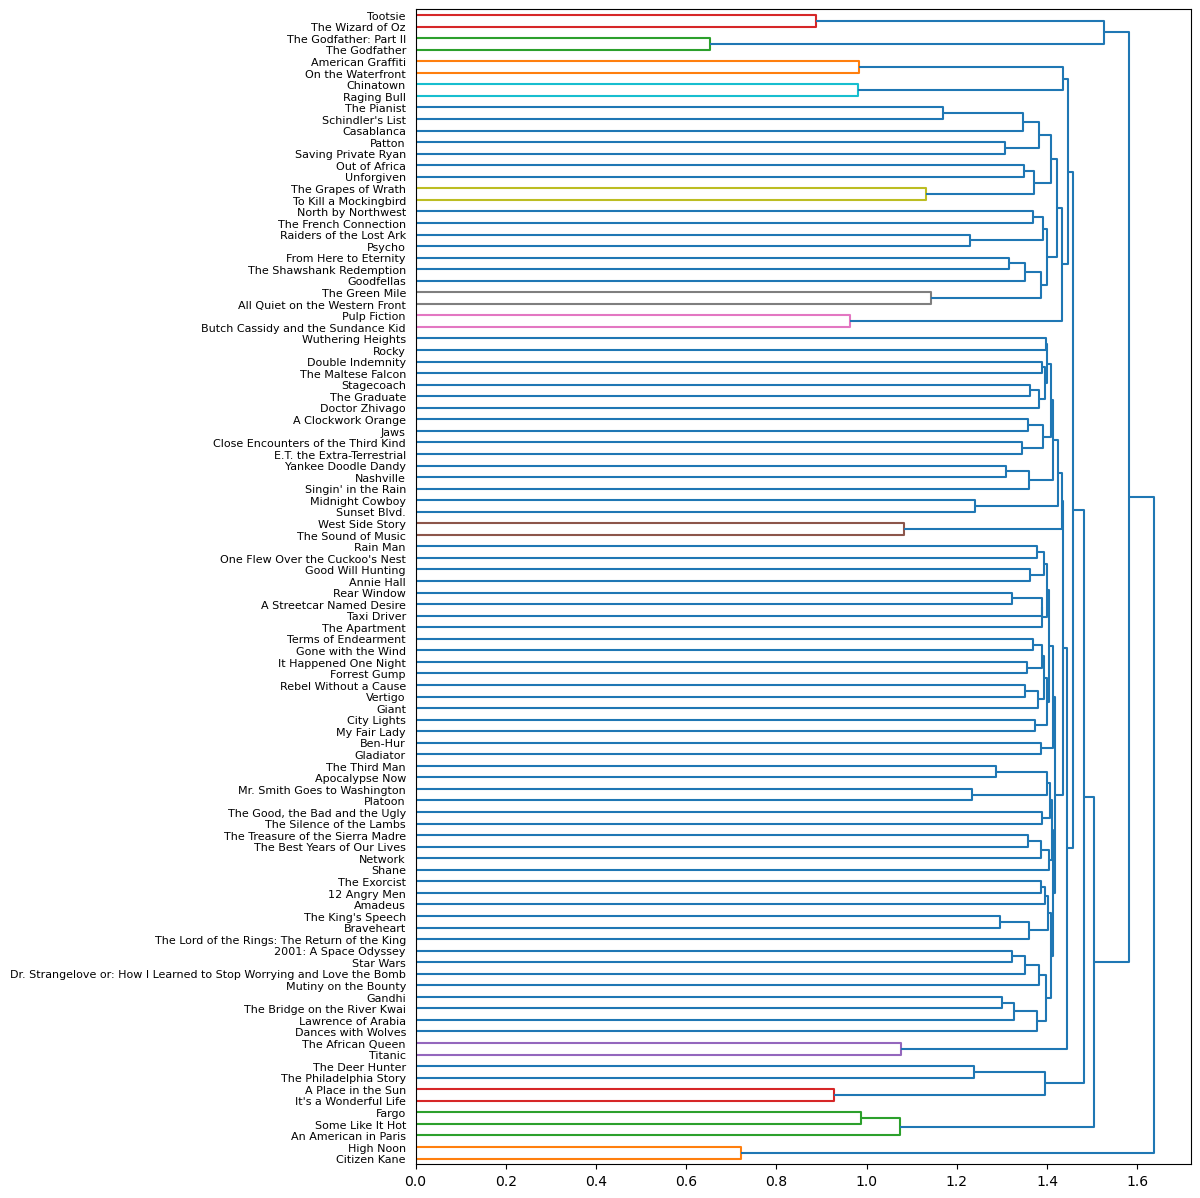

In [15]:
plt.figure(figsize=(10, 15))
_ = dendrogram(grouping_complete, leaf_label_func=lambda i: movie_data["Title"][i], leaf_font_size=8, orientation="right")

e. Quel est le nombre de groupes qui vous semble optimal, pour la méthode de votre choix ?  Pourquoi ?

**Réponse**: Les groupes correspondants aux couleurs du groupement _ward_ semble adéquats, soit 12. Le grand groupe central correspond aux films où les rapprochements se succèdent rapidement, et où il n'est pas évident à vue d'oeil de le diviser autrement. Les autre groupes de couleur périphériques sont rassemblés avec celui-ci plus tardivement, et contiennent des rapprochements évidents (films sur la Seconde Guerre Mondiale ou les films de la trilogie du _Parrain_).

## 4. Affichage des groupes et de leurs mots-clés

Dans cette section, vous utiliserez la méthode de groupement et le nombre de groupes choisis dans la section précédente.  Pour obtenir un nombre de groupe fixé à l'avance à partir de la matrice *linkage* obtenue au 3b ou 3d, vous pouvez utiliser la fonction `cut_tree`de Scipy. 

a. Pour chaque groupe, veuillez afficher :
* le numéro du groupe (commençant par 1)
* les titres des films du groupe
* le nombre de films dans le groupe

In [16]:
n_groups = 12
membership = cut_tree(grouping_ward, [n_groups])
groups = [[j for j in range(len(membership)) if membership[j] == i] for i in range(n_groups)]

In [17]:
for i, group in enumerate(groups):
    print(f"== Groupe {i+1} ==")
    print(f"Nombre de films: {len(group)}")
    print("Titres:\n  %s" % "\n  ".join(movie_data["Title"][group]))

== Groupe 1 ==
Nombre de films: 2
Titres:
  The Godfather
  The Godfather: Part II
== Groupe 2 ==
Nombre de films: 70
Titres:
  The Shawshank Redemption
  Casablanca
  One Flew Over the Cuckoo's Nest
  Gone with the Wind
  Lawrence of Arabia
  Psycho
  Sunset Blvd.
  Vertigo
  Forrest Gump
  Star Wars
  E.T. the Extra-Terrestrial
  2001: A Space Odyssey
  The Silence of the Lambs
  The Bridge on the River Kwai
  Singin' in the Rain
  12 Angry Men
  Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb
  Amadeus
  Apocalypse Now
  Gandhi
  The Lord of the Rings: The Return of the King
  Gladiator
  From Here to Eternity
  Unforgiven
  Raiders of the Lost Ark
  Rocky
  A Streetcar Named Desire
  The Philadelphia Story
  The Best Years of Our Lives
  My Fair Lady
  Ben-Hur
  Doctor Zhivago
  Jaws
  Braveheart
  The Good, the Bad and the Ugly
  The Treasure of the Sierra Madre
  The Apartment
  Platoon
  Dances with Wolves
  Goodfellas
  The Exorcist
  The Deer Hunter
  The 

b. Pour chacun des groupes précédents, veuillez afficher les six meilleurs mots-clés qui le caractérisent. On définit les mots-clés comme les mots (donc les dimensions résultant du `TfidfVectorizer`) qui ont les plus grands coefficients dans le centre de gravité du groupe.

In [18]:
n_keywords = 6
for i, group in enumerate(groups):
    idx = np.ravel(np.argsort(np.mean(feature_matrix[group], axis=0))[:, -1:-n_keywords-1:-1])
    print("Groupe %2d : %s" % (i + 1, " ".join(features[idx])))

Groupe  1 : michael corleone don vito roth fredo
Groupe  2 : the he tell take leave when
Groupe  3 : paul tom german patton schindler miller
Groupe  4 : jake gittes evelyn joey mulwray vickie
Groupe  5 : kane miller amy rosebud susan thatcher
Groupe  6 : dorothy michael julie witch toto sandy
Groupe  7 : rose allnut cal louisa jack african
Groupe  8 : terry curt johnny steve laurie edie
Groupe  9 : maria tony captain jet bernardo riff
Groupe 10 : george alice clarence angela potter lake
Groupe 11 : jerry joe henri carl lise gaear
Groupe 12 : butch marsellus sundance vincent jules posse


c. D'après les titres des films (et vos connaissances), les mots-clés obtenus sont-ils représentatifs des groupes ?

**Réponse**:

Pour les groupes 1 et 3 c'est plutôt représentatif (même personnages pour _Le Parrain_, _german_ pour les films tournant autour de la Seconde Guerre Mondiale).

D'autres groupes ont également des similarités par des coïncidences (groupe 7: le prénom Rose dans _Titanic_ et _The African Queen_, groupe 6: Dorothy dans _Tootsie_ et _Le Magicien D'Oz_).

Pour d'autre groups cela est moins évident, p.ex pour le grand groupe 2 où les mots-clés sont simplement des mots génériques. C'est sans doute cela qui explique sa différence et sa taille, les mots-clés de tous les autres groupes étant très majoritairement des noms. Il serait donc intéressant d'essayer de trouver d'autres sous-groupes dans celui-ci.

**Fin du Labo 3.**  Veuillez nettoyer ce notebook, afficher les résultats et les commentaires demandés, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.